# LLM Reference Architecture using Redis & Google Cloud Platform

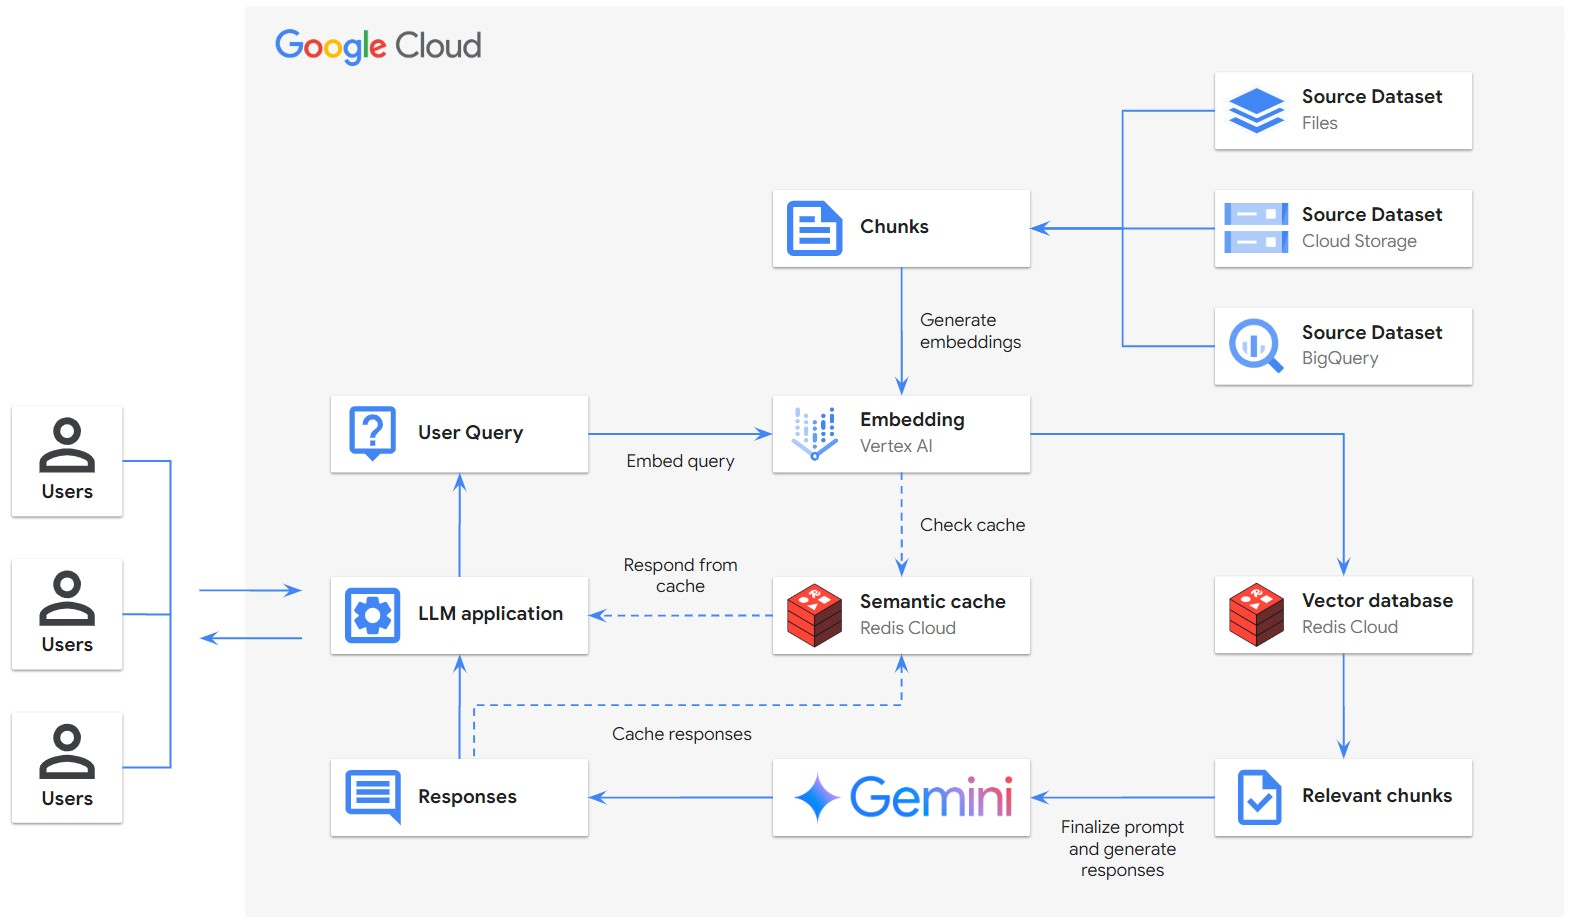

# Setup

## 1. Prerequisites

### Install required libraries

In [1]:
!pip install -U redisvl google-cloud-aiplatform langchain-community gradio pypdf

import IPython

app = IPython.Application.instance()
app.kernel.do_shutdown(True)

  Using cached pydantic-2.8.2-py3-none-any.whl.metadata (125 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.9/91.9 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 35.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 90.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 80.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.7/318.7 kB 32.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.8/295.8 kB 29.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 997.8/997.8 kB 63.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 394.9/394.9 kB 37.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.1/149.1 kB 17.1 

{'status': 'ok', 'restart': True}

### Connect to Redis server
Replace the connection params below with your own if you are connecting to an external Redis instance.

In [1]:
import os
import redis

# Redis connection params
REDIS_HOST = os.getenv("REDIS_HOST", "redis-xxx.region.gce.redns.redis-cloud.com")
REDIS_PORT = os.getenv("REDIS_PORT", "00000")
REDIS_PASSWORD = os.getenv("REDIS_PASSWORD", "FaKePaSsWoRd")

# Create Redis client
redis_client = redis.Redis(
  host=REDIS_HOST,
  port=REDIS_PORT,
  password=REDIS_PASSWORD
)

# Test connection
redis_client.ping()

# Clear Redis database ()
redis_client.flushdb()

True

### Set Google Cloud project information and initialize Vertex AI SDK for Python


In [2]:
# input your GCP project ID and region for Vertex AI
PROJECT_ID = "some-project-id"
REGION = "us-central1"

## 2. Obtain dataset

In [3]:
#Procure a dataset - downloading a publication from IRS
!mkdir resources
!wget https://www.irs.gov/pub/irs-pdf/p5718.pdf -P resources/

--2024-08-26 04:18:36--  https://www.irs.gov/pub/irs-pdf/p5718.pdf
Resolving www.irs.gov (www.irs.gov)... 23.37.3.228, 2600:141b:9000:58d::f50, 2600:141b:9000:587::f50
Connecting to www.irs.gov (www.irs.gov)|23.37.3.228|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8749823 (8.3M) [application/pdf]
Saving to: ‘resources/p5718.pdf’

p5718.pdf           100%[===================>]   8.34M  4.02MB/s    in 2.1s    

2024-08-26 04:18:39 (4.02 MB/s) - ‘resources/p5718.pdf’ saved [8749823/8749823]



### Set up embeddings
We define a helper function to create embeddings from a list of texts convert them to a byte string for efficient storage in Redis.



In [4]:
from redisvl.utils.vectorize import VertexAITextVectorizer

vectorizer = VertexAITextVectorizer(
    model = "text-embedding-004",
    api_config = {"project_id": PROJECT_ID, "location": REGION}
)

## 3. Generate Embeddings
The next step is to create chunks of the pdf and then embed each chunk as a vector.

In [5]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import PyPDFLoader

# set up the file loader/extractor and text splitter to create chunks
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=2500, chunk_overlap=0
)
loader = PyPDFLoader(
    file_path = "resources/p5718.pdf"
)

# extract, load, and make chunks
chunks = loader.load_and_split(text_splitter)

print("Done preprocessing. Created", len(chunks), "chunks of the original pdf resources/p5718.pdf")

# Embed each chunk content
embeddings = vectorizer.embed_many([chunk.page_content for chunk in chunks], as_buffer=True)

# Check to make sure we've created enough embeddings, 1 per document chunk
len(embeddings) == len(chunks)

Done preprocessing. Created 67 chunks of the original pdf resources/p5718.pdf


True

## 4. Create Index

Now that we have created embeddings that represent the text in our dataset, we will create an index that enables efficient search over the embeddings.


In [6]:
from redisvl.schema import IndexSchema
from redisvl.index import SearchIndex


index_name = "redisvl"

schema = IndexSchema.from_dict({
  "index": {
    "name": index_name,
    "prefix": "chunk"
  },
  "fields": [
    {
        "name": "chunk_id",
        "type": "tag",
        "attrs": {
            "sortable": True
        }
    },
    {
        "name": "content",
        "type": "text"
    },
    {
        "name": "text_embedding",
        "type": "vector",
        "attrs": {
            "dims": vectorizer.dims,
            "distance_metric": "cosine",
            "algorithm": "flat",
            "datatype": "float32"
        }
    }
  ]
})

In [7]:
# Create an index from schema and the client
index = SearchIndex(schema, redis_client)
index.create(overwrite=True, drop=True)

In [8]:
# Load expects an iterable of dictionaries
data = [
    {
        'chunk_id': f'{i}',
        'content': chunk.page_content,
        'text_embedding': embeddings[i]
    } for i, chunk in enumerate(chunks)
]

# RedisVL handles batching automatically
keys = index.load(data, id_field="chunk_id")

## 5. Query
Now we can use RedisVL to perform a variety of vector search operations.

In [9]:
from redisvl.query import VectorQuery

query = "What is TCC?"

query_embedding = vectorizer.embed(query)

vector_query = VectorQuery(
    vector=query_embedding,
    vector_field_name="text_embedding",
    num_results=3,
    return_fields=["chunk_id", "content"],
    return_score=True
)

# show the raw redis query
str(vector_query)

'*=>[KNN 3 @text_embedding $vector AS vector_distance] RETURN 3 chunk_id content vector_distance SORTBY vector_distance ASC DIALECT 2 LIMIT 0 3'

In [10]:
# execute the query with RedisVL
index.query(vector_query)

[{'id': 'chunk:12',
  'vector_distance': '0.496072769165',
  'chunk_id': '12',
  'content': '10 Publication  57181.3 Registration and Application Process\nExternal users must register with the current IRS credential service provider and complete \nthe IRIS Application for Transmitter Control Code (TCC) to submit transmissions using the \nIRIS intake platform. Information returns filed through the IRIS A2A system cannot be filed \nusing any other intake platform TCC. These include:\n• e-File Application (MeF)\n• Affordable Care Act (ACA) Application for TCC (AIR)\n• Partnership Bipartisan Budget Act (PBBA) Application for TCC\n• Information Returns (IR) Application for TCC (FIRE)\n• IRIS TCC for the Taxpayer Portal\n1.3.1 Registration \nBefore completing the IRIS Application for TCC, each user must create an account or sign-in \nusing their existing credentials to validate their identities using the latest authentication \nprocess. \nFor more information, please visit How to register fo

# Building a RAG Pipeline

In [11]:
#@title Setup RedisVL *AsyncSearchIndex*

from redis.asyncio import Redis
from redisvl.index import AsyncSearchIndex

# Create Redis client
redis_client = Redis(
    host=REDIS_HOST,
    port=REDIS_PORT,
    password=REDIS_PASSWORD
)

index = AsyncSearchIndex(index.schema)
await index.set_client(redis_client)

In [12]:
#@title Setup VertexAI Generative Model with Safety Settings
from vertexai.generative_models import GenerativeModel, Part, HarmCategory, HarmBlockThreshold


model = GenerativeModel("gemini-1.5-flash-001")

# Define safety settings
safety_settings = {
    HarmCategory.HARM_CATEGORY_HATE_SPEECH: HarmBlockThreshold.BLOCK_ONLY_HIGH,
    HarmCategory.HARM_CATEGORY_DANGEROUS_CONTENT: HarmBlockThreshold.BLOCK_ONLY_HIGH,
    HarmCategory.HARM_CATEGORY_SEXUALLY_EXPLICIT: HarmBlockThreshold.BLOCK_ONLY_HIGH,
    HarmCategory.HARM_CATEGORY_HARASSMENT: HarmBlockThreshold.BLOCK_ONLY_HIGH,
}

# Define generation config
generation_config = {
    "max_output_tokens": 2048,
    "temperature": 0.5,
    "top_p": 1
}

### Baseline Retrieval Augmented Generation

Below we build a simple RAG pipeline with three helper methods:


*   `answer_question` -- full RAG operation
* `retrieve_context` -- search Redis for relevant sources
* `promptify`  -- combine system instructions, user question, and sources



In [13]:
async def answer_question(index: AsyncSearchIndex, query: str):
    """Answer the user's question"""

    SYSTEM_PROMPT = """You are a helpful tax analyst assistant that has access
    to publications from the IRS
    """

    query_vector = vectorizer.embed(query)

    # Fetch context from Redis using vector search
    context = await retrieve_context(index, query_vector)

    prompt = f'''
    System: {SYSTEM_PROMPT}
    User: {promptify(query, context)}
    '''

    responses = model.generate_content(
        [prompt],
        generation_config=generation_config,
        safety_settings=safety_settings,
        stream=False
    )
    # Response provided by LLM
    if(responses.candidates[0].finish_reason.value == 1):
        return(responses.candidates[0].content.parts[0].text)
    else:
        return(f"Content has been blocked for {responses.candidates[0].finish_reason.name} reasons.")


async def retrieve_context(index: AsyncSearchIndex, query_vector) -> str:
    """Fetch the relevant context from Redis using vector search"""
    results = await index.query(
        VectorQuery(
            vector=query_vector,
            vector_field_name="text_embedding",
            return_fields=["content"],
            num_results=3
        )
    )
    content = "\n".join([result["content"] for result in results])
    return content


def promptify(query: str, context: str) -> str:
    return f'''Use the provided context below derived from public documenation to answer the user's question. If you can't answer the user's
    question, based on the context; do not guess. Do your best finding the answer in the context, but if there is no context at all,
    respond with "I don't know".

    User question:

    {query}

    Helpful context:

    {context}

    Answer:
    '''

# Improve performance and cut costs with LLM Semantic Caching

In [14]:
from redis import Redis
from redisvl.extensions.llmcache import SemanticCache

# Create Redis client
redis_client = Redis(
  host=REDIS_HOST,
  port=REDIS_PORT,
  password=REDIS_PASSWORD
)

# Create the Semantic Cache
llmcache = SemanticCache(
    name="llmcache",
    vectorizer=vectorizer,
    redis_client=redis_client,
    ttl=120,
    distance_threshold=0.2
)

In [15]:
from functools import wraps


# Create an LLM caching decorator
def cache(func):
    @wraps(func)
    async def wrapper(index, query_text, *args, **kwargs):
        query_vector = llmcache._vectorizer.embed(query_text)

        # Check the cache with the vector
        if result := llmcache.check(vector=query_vector):
            return result[0]['response']

        response = await func(index, query_text, query_vector=query_vector)
        llmcache.store(query_text, response, query_vector)
        return response
    return wrapper


@cache
async def answer_question(index: AsyncSearchIndex, query: str, **kwargs):
    """Answer the user's question"""

    SYSTEM_PROMPT = """You are a helpful tax analyst assistant that has access
    to publications from the IRS
    """

    # Fetch context from Redis using vector search
    context = await retrieve_context(index, kwargs["query_vector"])

    prompt = f'''
    System: {SYSTEM_PROMPT}
    User: {promptify(query, context)}
    '''

    responses = model.generate_content(
        [prompt],
        generation_config=generation_config,
        safety_settings=safety_settings,
        stream=False
    )
    # Response provided by LLM
    if(responses.candidates[0].finish_reason.value == 1):
        return(responses.candidates[0].content.parts[0].text)
    else:
        return(f"Content has been blocked for {responses.candidates[0].finish_reason.name} reasons.")


In [16]:
from datetime import datetime

query = "What is a JWK?"

startTime = datetime.now()
await answer_question(index, query)
print(f"Total time: {datetime.now() - startTime}")

Total time: 0:00:01.586129


In [17]:
# Now try again with semantic caching enabled!
query = "What's a JWK?"

startTime = datetime.now()
await answer_question(index, query)
print(f"Total time: {datetime.now() - startTime}")

Total time: 0:00:00.406613


In [18]:
import gradio as gr

async def respond(message, history):
    print(message)
    result = await answer_question(index, message)
    print(result)
    return result

gr.ChatInterface(respond).launch(debug=True)

04:22:00 httpx INFO   HTTP Request: GET https://api.gradio.app/gradio-messaging/en "HTTP/1.1 200 OK"
04:22:01 httpx INFO   HTTP Request: GET https://checkip.amazonaws.com/ "HTTP/1.1 200 "
04:22:01 httpx INFO   HTTP Request: GET http://127.0.0.1:7860/startup-events "HTTP/1.1 200 OK"
Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

04:22:01 httpx INFO   HTTP Request: HEAD http://127.0.0.1:7860/ "HTTP/1.1 200 OK"
Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
04:22:02 httpx INFO   HTTP Request: GET https://api.gradio.app/pkg-version "HTTP/1.1 200 OK"
04:22:02 httpx INFO   HTTP Request: GET https://api.gradio.app/v2/tunnel-request "HTTP/1.1 200 OK"
04:22:02 httpx INFO   HTTP Request: GET https://cdn-media.huggingface.co/frpc-gradio-0.2/frpc_linux_amd64 "HTTP/1.1 200 OK"
Running on public URL

what is JWK?
A JSON Web Key Set (JWKs) is used for e-Services API authentication. It contains a public key that validates the API consumer application. 

who should apply for a TCC?


Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/gradio/queueing.py", line 536, in process_events
    response = await route_utils.call_process_api(
  File "/usr/local/lib/python3.10/dist-packages/gradio/route_utils.py", line 321, in call_process_api
    output = await app.get_blocks().process_api(
  File "/usr/local/lib/python3.10/dist-packages/gradio/blocks.py", line 1935, in process_api
    result = await self.call_function(
  File "/usr/local/lib/python3.10/dist-packages/gradio/blocks.py", line 1518, in call_function
    prediction = await fn(*processed_input)
  File "/usr/local/lib/python3.10/dist-packages/gradio/utils.py", line 793, in async_wrapper
    response = await f(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/gradio/chat_interface.py", line 621, in _submit_fn
    response = await self.fn(*inputs)
  File "<ipython-input-18-8916434cc5dd>", line 5, in respond
    result = await answer_question(index, message)
  File "<ipyt

who should apply for a TCC?
You should apply for an IRIS TCC if you are transmitting information returns to the IRS or if you are developing software to file information returns electronically. 

what is TCC?
TCC stands for **Transmitter Control Code**. 

The document explains that it is a code used to identify the business acting as the transmitter of the file. 

Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://7a184ae5d06c942b5a.gradio.live
